In [2]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
import random
import matplotlib
from matplotlib import pyplot as plt
import statistics
from pandas import DataFrame
from datetime import datetime
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras import backend as K
#import keras.backend.tensorflow_backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from os.path import basename
#import seaborn as sns
# from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam




# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13465115864032074423
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2108132172515744278
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1066485121061906001
physical_device_desc: "device: 1, name: TITAN RTX, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


In [3]:
workdir = "D://ResNetIC50//Dataset//MEYODG-51K"

In [4]:
# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]

dataset = np.load(workdir + "//MEYODG51K_dataset.npz") # input file
ss0 = np.load(workdir + '//MEYODG51K_dataset_r2.npz') # split for training and test

In [5]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [6]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# # In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [7]:
# In[15]:
ab =[]
for i in range(100,300):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

0 27


In [8]:
x.shape

(51787, 79724)

In [9]:
training_image_array.shape

(46609, 79724)

In [10]:
# In[21]:

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
# img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [12]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
#input_shape = (img_rows, img_cols, 1)

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(46609, 79724, 1) (46609,) (5178, 79724, 1) (5178,)


In [14]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (46609, 79724, 1)
46609 train samples
5178 test samples


In [15]:
training_image_array.shape

(46609, 79724)

In [16]:
# In[10]:
with tf.device('/GPU:0'):
    inputs = Input(shape=(train_X.shape[1],1),name='inputs')

    x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
    x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
#     y = x
    x = Activation('tanh')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)
    
    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

#     x = AveragePooling1D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(units=2048, name='dense1'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout1') (x)
    x = Activation('relu')(x)

#    x = Reshape((300,1))(x)

#    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = BatchNormalization()(x)

    x = Dense(units=1024, name='dense5'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout5') (x)
    x = Activation('relu')(x)

    x = Dense(units=512, name='dense6'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout6') (x)
    x = Activation('relu')(x)

    x = Dense(units=1024, name='dense7'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout7') (x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Dense(units=512, name='dense8'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout8') (x)
    x = Activation('relu')(x)
    
    x = Dense(units=256, name='dense9'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout9') (x)
    x = Activation('relu')(x)

    x = Dense(units=128, name='dense10'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout10') (x)
    x = Activation('relu')(x)


    predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
#     predictions = Dense(1, activation='linear', name='predictions')(x)

    

    model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['mse','mae'])


    model.summary()


Model: "Test_v2_DNN20190327"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 79724, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 39862, 16)    64          inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 7972, 16)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7972, 16)     64          max_pooling1d[0][0]              
________________________________________________________________________________

In [17]:
StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with tf.device('/GPU:0'):
    model_train = model.fit(train_X, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2022-02-04 21:14:18.277790
Epoch 1/150
467/467 [==============================] - 119s 239ms/step - loss: 10.1265 - mse: 10.1265 - mae: 2.6115 - val_loss: 3.6039 - val_mse: 3.6039 - val_mae: 1.4908
Epoch 2/150
467/467 [==============================] - 112s 241ms/step - loss: 2.0568 - mse: 2.0568 - mae: 1.0947 - val_loss: 1.9727 - val_mse: 1.9727 - val_mae: 1.0514
Epoch 3/150
467/467 [==============================] - 115s 245ms/step - loss: 1.8128 - mse: 1.8128 - mae: 1.0257 - val_loss: 1.6401 - val_mse: 1.6401 - val_mae: 0.9538
Epoch 4/150
467/467 [==============================] - 115s 247ms/step - loss: 1.6696 - mse: 1.6696 - mae: 0.9834 - val_loss: 1.5524 - val_mse: 1.5524 - val_mae: 0.9234
Epoch 5/150
467/467 [==============================] - 115s 247ms/step - loss: 1.5681 - mse: 1.5681 - mae: 0.9547 - val_loss: 1.9816 - val_mse: 1.9816 - val_mae: 1.0853
Epoch 6/150
467/467 [==============================] - 115s 246ms/step - loss: 1.3865 - mse: 1.3865 - mae: 0.8917 

467/467 [==============================] - 113s 243ms/step - loss: 0.2698 - mse: 0.2698 - mae: 0.3887 - val_loss: 1.0060 - val_mse: 1.0060 - val_mae: 0.7213
Epoch 50/150
467/467 [==============================] - 113s 243ms/step - loss: 0.2574 - mse: 0.2574 - mae: 0.3875 - val_loss: 0.9583 - val_mse: 0.9583 - val_mae: 0.7055
Epoch 51/150
467/467 [==============================] - 113s 243ms/step - loss: 0.2038 - mse: 0.2038 - mae: 0.3504 - val_loss: 0.9948 - val_mse: 0.9948 - val_mae: 0.7198
Epoch 52/150
467/467 [==============================] - 113s 243ms/step - loss: 0.2193 - mse: 0.2193 - mae: 0.3613 - val_loss: 1.0199 - val_mse: 1.0199 - val_mae: 0.7166
Epoch 53/150
467/467 [==============================] - 113s 243ms/step - loss: 0.4153 - mse: 0.4153 - mae: 0.4685 - val_loss: 0.9877 - val_mse: 0.9877 - val_mae: 0.7052
Epoch 54/150
467/467 [==============================] - 113s 243ms/step - loss: 0.2187 - mse: 0.2187 - mae: 0.3584 - val_loss: 0.9579 - val_mse: 0.9579 - val_mae: 

467/467 [==============================] - 113s 243ms/step - loss: 0.0861 - mse: 0.0861 - mae: 0.2258 - val_loss: 0.9531 - val_mse: 0.9531 - val_mae: 0.6900
Epoch 146/150
467/467 [==============================] - 113s 243ms/step - loss: 0.1220 - mse: 0.1220 - mae: 0.2631 - val_loss: 0.9638 - val_mse: 0.9638 - val_mae: 0.6923
Epoch 147/150
467/467 [==============================] - 113s 243ms/step - loss: 0.1218 - mse: 0.1218 - mae: 0.2591 - val_loss: 0.9720 - val_mse: 0.9720 - val_mae: 0.7030
Epoch 148/150
467/467 [==============================] - 113s 243ms/step - loss: 0.1978 - mse: 0.1978 - mae: 0.3186 - val_loss: 0.9689 - val_mse: 0.9689 - val_mae: 0.6927
Epoch 149/150
467/467 [==============================] - 113s 242ms/step - loss: 0.1004 - mse: 0.1004 - mae: 0.2424 - val_loss: 0.9607 - val_mse: 0.9607 - val_mae: 0.6983
Epoch 150/150
467/467 [==============================] - 113s 243ms/step - loss: 0.0870 - mse: 0.0870 - mae: 0.2267 - val_loss: 0.9668 - val_mse: 0.9668 - val_

In [18]:
import json
workdir = "D://ResNetIC50//Result//MEYODG-51K//ResNet"
# Option 1: Save Weights + Architecture
model.save_weights(workdir+ '//MEYODG51K_ResNet_r2_model_fix_v3.h5')
with open(workdir + '//MEYODG51K_ResNet_r2_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [19]:
# Option 2: Save/Load the Entire Model
# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//MEYODG51K_ResNet_r2_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [20]:
test_eval = model.evaluate(test_X, test_label_array, verbose=1)

162/162 [==============================] - 5s 28ms/step - loss: 0.9668 - mse: 0.9668 - mae: 0.6964


In [21]:
test_eval

[0.9667516350746155, 0.9667516350746155, 0.6964474320411682]

In [22]:
accuracy = model_train.history['mse']
val_accuracy = model_train.history['val_mse']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [23]:
import matplotlib
from matplotlib import pyplot as plt

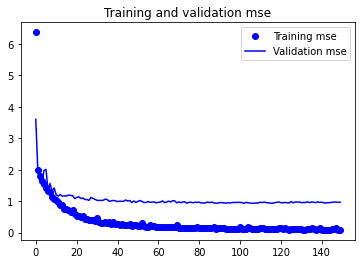

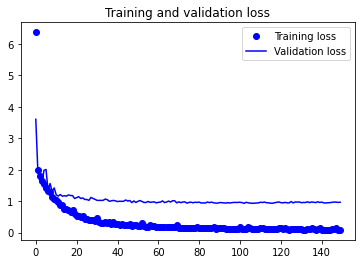

In [24]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
predicted_classes = model.predict(test_X)

In [26]:
predicted_value = predicted_classes

In [27]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [28]:
c.to_csv(workdir + '//MEYODG51K_ResNet_r2_pred_obs_table.csv')

In [29]:
c

,Predicted,Test
0,3.240485,3.455613
1,2.192159,1.777574
2,0.692491,0.871086
3,5.221569,3.506734
4,0.066692,0.079714
...,...,...
5173,4.152795,3.918200
5174,3.541193,3.739676
5175,5.044422,2.720437
5176,4.878338,3.543666


In [30]:
predicted_value.shape

(5178, 1)

In [31]:
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.8863617170883393, intercept=0.2875438370369239, rvalue=0.9370599918123943, pvalue=0.0, stderr=0.004590726223760387, intercept_stderr=0.01581575412643225)

In [32]:
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

0.877532365374408


In [33]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.9832351818290004


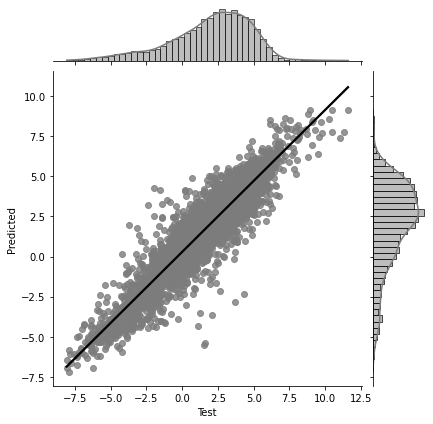

In [34]:
workdir = "D://ResNetIC50//Result//Figure//MEYODG-51K"
import seaborn as sns

g = sns.jointplot(x="Test", y="Predicted", data=c, kind='reg', color='#7C7C7C',
                  joint_kws={'line_kws':{'color':'black'}})
g.savefig(workdir+ '//MEYODG51K_ResNet_r2.png', dpi=300)